In [4]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from WanPy import *
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier
import models
import plotting as plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/Users/treycole/Codes/WanPy/top_obstruction


In [5]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.3

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

#############

n_orb = model.get_num_orbitals()
lat_vecs = model.get_lat()
orb_vecs = model.get_orb()
low_E_sites = np.arange(0, n_orb, 2)
high_E_sites = np.arange(1, n_orb, 2)
n_occ = int(n_orb/2)

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0


In [6]:
### Trial wavefunctions

# only one should be true
random = False
low_E = False
omit = True

if random:
    omit_num = 2
    n_tfs = n_occ - omit_num
    tf_list = ["random", n_tfs]
elif omit:
    omit_sites = 6
    tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site
    # np.random.choice(low_E_sites, n_tfs, replace=False)
    n_tfs = len(tf_list)
elif low_E:
    tf_list = list(low_E_sites)
    n_tfs = len(tf_list)

Wan_frac = n_tfs/n_occ

if random:
    save_sfx = model_str + f'_tfxs={tf_list}'
else:
    save_sfx = model_str + f'_tfx={np.array(tf_list, dtype=int)}'

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {Wan_frac}")
print(save_sfx)

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75
C=1.0_Delta=1_t=1_t2=-0.3_tfx=[0 2 4]


In [7]:
sv_dir = 'data'
if not os.path.exists(sv_dir):
    os.makedirs(sv_dir)
    
sv_prefix = 'WF_max_loc'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

WF = np.load(f"{file_name}.npy", allow_pickle=True).item()

sv_prefix = 'WF_loc_steps'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"

loc_steps = np.load(f"{file_name}.npy", allow_pickle=True).item()

In [8]:
for key, val in loc_steps.items():
    print(f"{key} Omega = {sum(val['Omega'])}")

P Omega = 0.7936988643466638
P+ML Omega = 0.791690167837925
P+SS+P Omega = 0.6064764685710871
P+SS+P+ML Omega = 0.605573661407319


In [10]:
loc_steps

{'P': {'Omega': array([0.26456629, 0.26456629, 0.26456629]),
  'Omega_i': np.float64(0.686829895018576),
  'Omega_til': np.float64(0.10686896932809825),
  'centers': array([[0.16759885, 0.16759885],
         [0.16759885, 0.6648023 ],
         [0.6648023 , 0.16759885]])},
 'P+ML': {'Omega': array([0.26389672, 0.26389672, 0.26389672]),
  'Omega_i': np.float64(0.6868298950198835),
  'Omega_til': np.float64(0.104860272818077),
  'centers': array([[0.16760902, 0.16760902],
         [0.16760902, 0.66478196],
         [0.66478196, 0.16760902]]),
  'iter_num': 100000},
 'P+SS+P': {'Omega': array([0.20215882, 0.20215882, 0.20215882]),
  'Omega_i': np.float64(0.5706005404449854),
  'Omega_til': np.float64(0.03587592812612753),
  'centers': array([[0.16122704, 0.16122704],
         [0.16122704, 0.67754592],
         [0.67754592, 0.16122704]]),
  'iter_num': 100000},
 'P+SS+P+ML': {'Omega': array([0.20185789, 0.20185789, 0.20185789]),
  'Omega_i': np.float64(0.5706005404460939),
  'Omega_til': np.

In [16]:
print(loc_steps['P+SS+P']['Omega'])
print(loc_steps['P+SS+P']['Omega_i']/3)
print(loc_steps['P+SS+P']['Omega_til']/3)

[0.20215882 0.20215882 0.20215882]
0.19020018014832848
0.011958642708709178


# Generating Maximally Localized Wannier Functions

In [5]:
nks = 20, 20
WF = Wannier(model, nks)
loc_steps = {}

In [6]:
WF.single_shot(tf_list)
WF.report()
loc_steps["P"] = {"Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til, "centers": WF.get_centers()}

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.26457
w_1 --> 0.26457
w_2 --> 0.26457
Centers:
w_0 --> [0.1676 0.1676]
w_1 --> [0.1676 0.6648]
w_2 --> [0.6648 0.1676]
Omega_i = 0.686829895018576
Omega_tilde = 0.10686896932809825


In [10]:
iter_num = 100000

WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-30, grad_min=1e-10, verbose=True)

loc_steps["P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

WF.report()

0 Omega_til = 0.10669104651335858, Grad mag: 1.357481504469807e-13
1 Omega_til = 0.10654054708315011, Grad mag: 1.848849806523535e-13
2 Omega_til = 0.10641219500577913, Grad mag: 1.714404868370306e-13
3 Omega_til = 0.10628987595237832, Grad mag: 1.3103136663148012e-13
4 Omega_til = 0.10617315832253817, Grad mag: 1.4862576714457663e-13
5 Omega_til = 0.10607269071495169, Grad mag: 1.0101413692063569e-13
6 Omega_til = 0.10597617437889233, Grad mag: 1.724314314237091e-13
7 Omega_til = 0.105892574121314, Grad mag: 1.4301668437942695e-13
8 Omega_til = 0.10581181923635248, Grad mag: 1.6493593222725624e-13
9 Omega_til = 0.105741510950494, Grad mag: 1.4628857994863726e-13
10 Omega_til = 0.10567328598383126, Grad mag: 2.7081394395875455e-13
11 Omega_til = 0.1056136318486762, Grad mag: 1.1476673777429487e-13
12 Omega_til = 0.10555552400135858, Grad mag: 1.9014986357906092e-13
13 Omega_til = 0.10550453219465647, Grad mag: 1.9064280327094107e-13
14 Omega_til = 0.10545965860504483, Grad mag: 1.91271

In [11]:
nks = 20, 20
WF = Wannier(model, nks)

# initial projection
WF.single_shot(tf_list)

# subspace selection
iter_num = 100000
WF.subspace_selec(iter_num=iter_num, tol=1e-10, verbose=True)

# second projection
psi_til_til = WF.get_psi_tilde(
        WF.tilde_states._psi_wfs, WF.trial_wfs, 
        state_idx=list(range(WF.tilde_states._psi_wfs.shape[2]))
        )
WF.set_tilde_states(psi_til_til, cell_periodic=False)

loc_steps["P+SS+P"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

# max-loc
iter_num = 100000
WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-10, grad_min=1e-10, verbose=True)

loc_steps["P+SS+P+ML"] = {
    "Omega": WF.spread, "Omega_i": WF.omega_i, "Omega_til": WF.omega_til,
    "centers": WF.get_centers(), "iter_num": iter_num}

sv_dir = 'data'

# sv_prefix = 'WF_loc_steps'
# file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
# np.save(file_name, loc_steps)

# sv_prefix = 'WF_max_loc'
# file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}"
# np.save(file_name, WF)

0 Omega_I: 0.6830214299968553
1 Omega_I: 0.6797149142683037
2 Omega_I: 0.6767086615068956
3 Omega_I: 0.6739084346802983
4 Omega_I: 0.6712629121510038
5 Omega_I: 0.6687413160399324
6 Omega_I: 0.6663237970475502
7 Omega_I: 0.6639967761915254
8 Omega_I: 0.6617504911137851
9 Omega_I: 0.6595776180000834
10 Omega_I: 0.6574724563984408
11 Omega_I: 0.6554304256408731
12 Omega_I: 0.653447742020193
13 Omega_I: 0.6515212050942708
14 Omega_I: 0.649648052198502
15 Omega_I: 0.6478258569055119
16 Omega_I: 0.6460524565669261
17 Omega_I: 0.6443258995602563
18 Omega_I: 0.6426444061695772
19 Omega_I: 0.6410063390778278
20 Omega_I: 0.6394101807505977
21 Omega_I: 0.6378545158379918
22 Omega_I: 0.6363380172831313
23 Omega_I: 0.634859435205672
24 Omega_I: 0.6334175878895579
25 Omega_I: 0.6320113543859263
26 Omega_I: 0.6306396683708337
27 Omega_I: 0.6293015129887095
28 Omega_I: 0.6279959164790416
29 Omega_I: 0.6267219484321298
30 Omega_I: 0.6254787165550704
31 Omega_I: 0.6242653638560413
32 Omega_I: 0.6230810

In [12]:
for key, val in loc_steps.items():
    print(f"{key} Omega = {sum(val['Omega']): .4f}")

P Omega =  0.7937
P+ML Omega =  0.7917
P+SS+P Omega =  0.6065
P+SS+P+ML Omega =  0.6054


In [3]:
loc_steps['P']

NameError: name 'loc_steps' is not defined

In [13]:
loc_steps

{'P': {'Omega': array([0.26456629, 0.26456629, 0.26456629]),
  'Omega_i': np.float64(0.686829895018576),
  'Omega_til': np.float64(0.10686896932809825),
  'centers': array([[0.16759885, 0.16759885],
         [0.16759885, 0.6648023 ],
         [0.6648023 , 0.16759885]])},
 'P+ML': {'Omega': array([0.26389672, 0.26389672, 0.26389672]),
  'Omega_i': np.float64(0.6868298950198835),
  'Omega_til': np.float64(0.104860272818077),
  'centers': array([[0.16760902, 0.16760902],
         [0.16760902, 0.66478196],
         [0.66478196, 0.16760902]]),
  'iter_num': 100000},
 'P+SS+P': {'Omega': array([0.20215882, 0.20215882, 0.20215882]),
  'Omega_i': np.float64(0.570600540445156),
  'Omega_til': np.float64(0.035875914496406903),
  'centers': array([[0.16122705, 0.16122705],
         [0.16122705, 0.67754591],
         [0.67754591, 0.16122705]]),
  'iter_num': 100000},
 'P+SS+P+ML': {'Omega': array([0.2018015, 0.2018015, 0.2018015]),
  'Omega_i': np.float64(0.5706005404463497),
  'Omega_til': np.flo

# Plotting

In [7]:
# nks = 20, 20
# WF = Wannier(model, nks)
# WF.single_shot(tf_list)
# WF.ss_maxloc(
#     iter_num_omega_i=100000, iter_num_omega_til=100000, eps=1e-3,
#     tol_omega_i=1e-30, tol_omega_til=1e-30, grad_min=1e-11, verbose=True, alpha=0.5)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

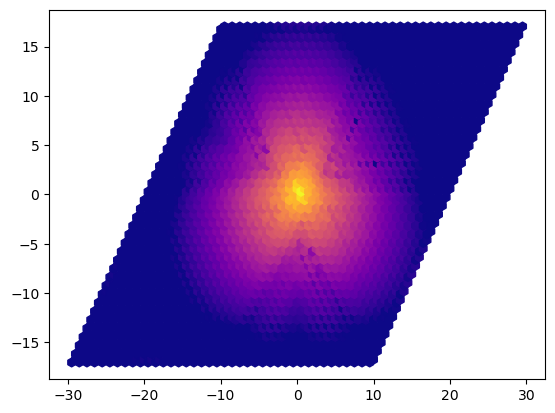

In [7]:
WF.plot_density(0, show_lattice=False, lat_size=2, cbar=False, return_fig=True, interpolate=False)

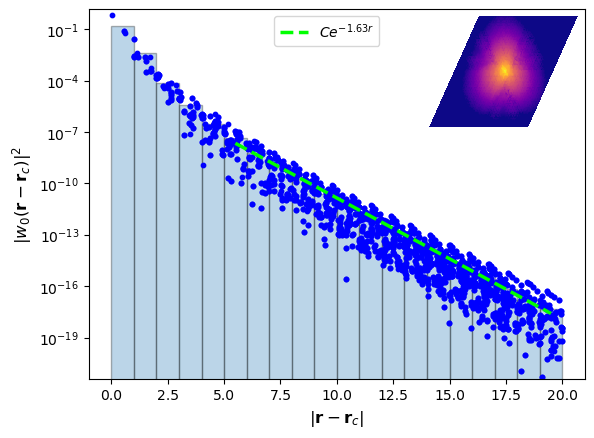

In [8]:
idx = 0
fig, ax = WF.plot_decay(idx, fit_rng=[5, 20], return_fig=True)
ax.legend(bbox_to_anchor=(0.6, 1.0))
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper right')  # You can adjust size and location
fig, inset_ax = WF.plot_density(
    idx, show_lattice=False, lat_size=2, cbar=False, interpolate=True, fig=fig, ax=inset_ax, return_fig=True)
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('off')
plt.savefig(f'images/decay_and_dens_{save_sfx}.png', dpi=700)

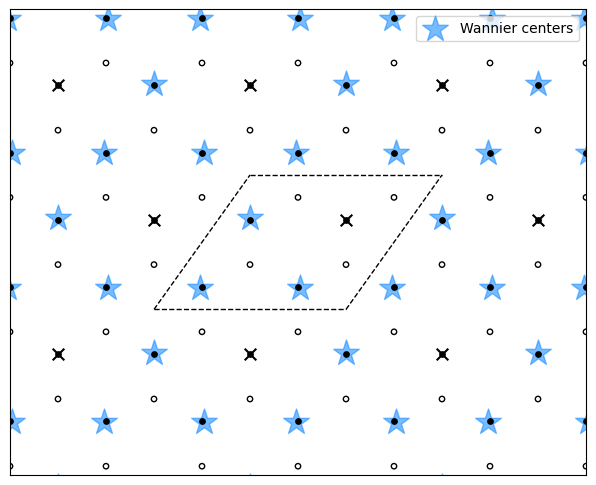

In [9]:
title = (
  "Haldane model \n"
  fr"$C = {chern: .1f}$, $\Delta = {delta}$, $t= {t: .2f}, t_2 = {t2: .2f}$"
  )

kwargs_centers = {'marker': '*', 'c': 'dodgerblue', 'alpha': 0.6} 
kwargs_omit = {'s': 70, 'marker': 'x', 'c': 'k', 'zorder': 3} 
kwargs_lat = {'s': 15, 'marker': 'o', 'c': 'k'} 

fig, ax = WF.plot_centers(
    title=title, center_scale=50, omit_sites=[omit_sites], section_home_cell=True, 
    color_home_cell=True, translate_centers=True, kwargs_centers=kwargs_centers, 
    kwargs_lat=kwargs_lat, kwargs_omit=kwargs_omit, pmx=3, pmy=3, legend=True)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('')

sv_dir = 'images'
sv_prefix = 'Wan_centers'
file_name = f"{sv_dir}/{sv_prefix}_{save_sfx}.png"

# plt.subplots_adjust(top=1, left=0, bottom=0, right=1)
plt.subplots_adjust(top=0.98, left=0.05, bottom=0.01, right=.95)

plt.savefig(file_name, dpi=700)

In [10]:
u_energy = WF.energy_eigstates.get_states()["Cell periodic"]  # energy eigenstates
P, Q = WF.energy_eigstates.get_projector(return_Q=True)  # full band projector

u_occ = u_energy[..., :n_occ, :]  # occupied energy eigenstates
P_occ = np.einsum("...ni, ...nj -> ...ij", u_occ, u_occ.conj())  # occupied band projector
Q_occ = np.eye(P_occ.shape[-1]) - P_occ[..., :, :]  # occ complement

u_tilde = WF.tilde_states.get_states()["Cell periodic"]  # reduced tilde states
P_tilde, Q_tilde = WF.tilde_states.get_projector(return_Q=True)  # tilde space projectors

## Projectors on full mesh
P_diff = P_occ - P_tilde  # complementary subspace

eigvals, eigvecs = np.linalg.eigh(P_diff)  # states spanning complement
u_comp = eigvecs[..., :, -1]  # take state with non-zero eigval
u_comp = u_comp[..., np.newaxis, :]  # single state

In [11]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)

# Actual eigenstates and eigenenergies
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)

# Complementary subspace interpolated energies and states
interp_energies_comp, interp_unk_comp = WF.interp_energies(k_vec, u_tilde=u_comp, ret_eigvecs=True) 

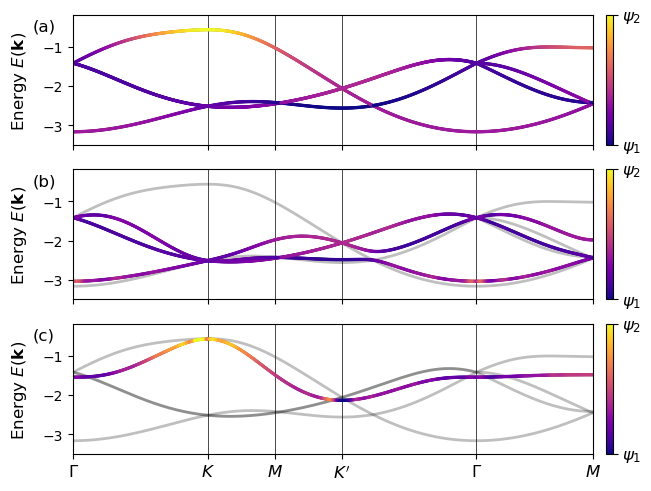

In [14]:
fig, axs = plt.subplots(3, 1, sharex=True, constrained_layout=True)

############# subplot a ####################

# Actual bands
wt = abs(evecs)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(evals.shape[-1]):
    axs[0].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0)

    scat = axs[0].scatter(
        k_dist, evals[:, n], c=col[:, n], 
        cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

# # Reduced bands
# for n in range(interp_energies.shape[-1]):
#     axs[0].plot(k_dist, interp_energies[:, n], c='k', lw=2, zorder=0)

# # Complementary bands
# for n in range(interp_energies_comp.shape[-1]):
#     axs[0].plot(k_dist, interp_energies_comp[:, n], c='k', lw=2, zorder=0)
    

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_2$', r'$\psi_1$'], size=12)

axs[0].set_xlim(0, k_node[-1])
axs[0].set_xticks(k_node)
for n in range(len(k_node)):
    axs[0].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs[0].set_xticklabels(k_label, size=12)

axs[0].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[0].yaxis.labelpad = 10

# ax.set_title(title)
axs[0].set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
axs[0].set_ylim(-3.5, -0.18)
axs[0].set_xticks([ ])
# axs[0].legend()

axs[0].text(-.1, -0.6, '(a)', size=12)

############# subplot b ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[1].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# Reduced bands
wt = abs(interp_unk)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies.shape[-1]):
    axs[1].plot(k_dist, interp_energies[:, n], c='k', lw=2, zorder=0)

    scat = axs[1].scatter(
            k_dist, interp_energies[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)

# # Complementary bands
# for n in range(interp_energies_comp.shape[-1]):
#     axs[1].plot(k_dist, interp_energies_comp[:, n], c='k', lw=2, zorder=0)
    

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_2$', r'$\psi_1$'], size=12)

axs[1].set_xlim(0, k_node[-1])
axs[1].set_xticks(k_node)
for n in range(len(k_node)):
    axs[1].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs[1].set_xticklabels(k_label, size=12)

axs[1].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[1].yaxis.labelpad = 10

# ax.set_title(title)
axs[1].set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
axs[1].set_ylim(-3.5, -0.18)
axs[1].set_xticks([ ])
# axs[1].legend()

axs[1].text(-.1, -0.6, '(b)', size=12)


############# subplot c ####################

# Actual bands
for n in range(evals.shape[-1]):
    axs[2].plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

# # Reduced bands
# for n in range(interp_energies.shape[-1]):
#     axs[2].plot(k_dist, interp_energies[:, n], c='k', lw=2, zorder=0)

# Complementary bands
wt = abs(interp_unk_comp)**2
col = np.sum([ wt[..., i] for i in high_E_sites], axis=0)
for n in range(interp_energies_comp.shape[-1]):
    axs[2].plot(k_dist, interp_energies_comp[:, n], c='k', lw=2, zorder=0)

    scat = axs[2].scatter(
            k_dist, interp_energies_comp[:, n], c=col[:, n], 
            cmap='plasma', marker='o', s=2, vmin=0, vmax=1, zorder=2)
    

cbar = fig.colorbar(scat, ticks=[1,0], pad=0.01)
cbar.ax.set_yticklabels([r'$\psi_2$', r'$\psi_1$'], size=12)

axs[2].set_xlim(0, k_node[-1])
axs[2].set_xticks(k_node)
for n in range(len(k_node)):
    axs[2].axvline(x=k_node[n], linewidth=0.5, color='k', zorder=1)
if k_label is not None:
    axs[2].set_xticklabels(k_label, size=12)

axs[2].set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
axs[2].yaxis.labelpad = 10

# ax.set_title(title)
axs[2].set_ylabel(r"Energy $E(\mathbf{{k}})$ ")
axs[2].set_ylim(-3.5, -0.18)
# axs[2].set_xticks([ ])
# axs[2].legend()

axs[2].text(-.1, -0.6, '(c)', size=12)

# plt.subplots_adjust(top=.97, left=0.13, bottom=0.07, right=1.06, hspace=0.07)

# fig.set_size_inches()
# plt.savefig(f"images/interp_{band_type}_bands.png", dpi=700)
plt.savefig(f"images/interp_all_bands_{save_sfx}.png", dpi=700)